# Replicando el trabajo de Dickey y Fuller

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t as t_Student

plt.style.use('seaborn')
plt.rc('figure', figsize=(15,4))
plt.rc('axes', titlesize=20, labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

## Distribución de Dickey-Fuller

La siguiente función genera una muestra aleatoria de `T` datos, estima tres regresiones (todas ellas la serie contra su primer rezago, difieren en los términos estocásticos) y retorna los respectivos estadísticos *t* estimados.

In [2]:
def df_simulacion(T=101):
    e = np.random.randn(T)
    y = e.cumsum()
    dy = y[1:]-y[:-1]
    X = sm.add_constant(y[:-1])
    Z = np.c_[X,np.arange(T-1)]
    
    res0 = sm.OLS(dy, y[:-1], hasconst=False).fit()
    res1 = sm.OLS(dy, X, hasconst=True).fit()
    res2 = sm.OLS(dy, Z, hasconst=True).fit()
    return res0.tvalues[0], res1.tvalues[1], res2.tvalues[1]

Por ejemplo, esta simulación da estos tres valores del estadístico *t*: uno solo la serie rezagada, el segundo agrega un intercepto, y el tercero un intercepto y una tendencia determinística.

In [3]:
df_simulacion()

(-0.2998482471977347, -2.0616748312899924, -1.1805438301193598)

### Simulando los estadísticos (secuencialmente)

Simulemos una muestra de 100 mil observaciones.

In [4]:
N = 100_000

In [5]:
%%time
dfvalues = pd.DataFrame([df_simulacion() for _ in range(N)], columns=['nc','c','ct'])

Wall time: 2min


### Simulando los estadíticos (en paralelo)

Vemos que tarda bastante tiempo (cerca de 2 minutos en mi PC). La mayoría de los computadores modernos contienen un procesador de varios núcleos, por lo que podríamos ejecutar esta simulación más rápidamente si utilizamos todos los núcleos disponibles (aprovechando que todas las realizaciones de nuestra simulación deben ser independientes). Para ello definimos la función `Monte_Carlo`

In [20]:
from joblib import Parallel, delayed

def Monte_Carlo(funcion, repeticiones, columnas, *args, **kwargs):
    """
    Ejecuta simulaciones de Montecarlo en paralelo, aprovechando todos los núcleos del procesador

    Argumentos:
        funcion: una función que dé por resultado una única realización de las cantidades que se desean simular
        repeticiones: un entero que indica cuántas muestras se desean simular
        columnas: una lista (o tupla) de strings, que identifiquen a las cantidades individuales retornadas por funcion
        *args, **kwargs: otros parámetros requeridos por funcion

    Retorna:
         Un data frame de pandas, con tantas filas como `repeticiones` y columnas como textos en `columnas`.
    """
    datos = Parallel(n_jobs=-1)(delayed(funcion)(*args, **kwargs) for _ in range(repeticiones))
    return pd.DataFrame(datos, columns=columnas)

In [16]:
%%time
dfvalues = Monte_Carlo(df_simulacion, N, ['nc','c','ct'])

Wall time: 38.7 s


En mi PC, que contiene un procesador de 4 núcleos, el tiempo se redujo de 2 minutos a solo 33 segundos (el tiempo exacto cambia de una ejecución a otra).  En adelante, seguiremos utilizando la función `Monte_Carlo` para hacer las simulaciones en paralelo.

### Graficando la distribución de Dickey-Fuller

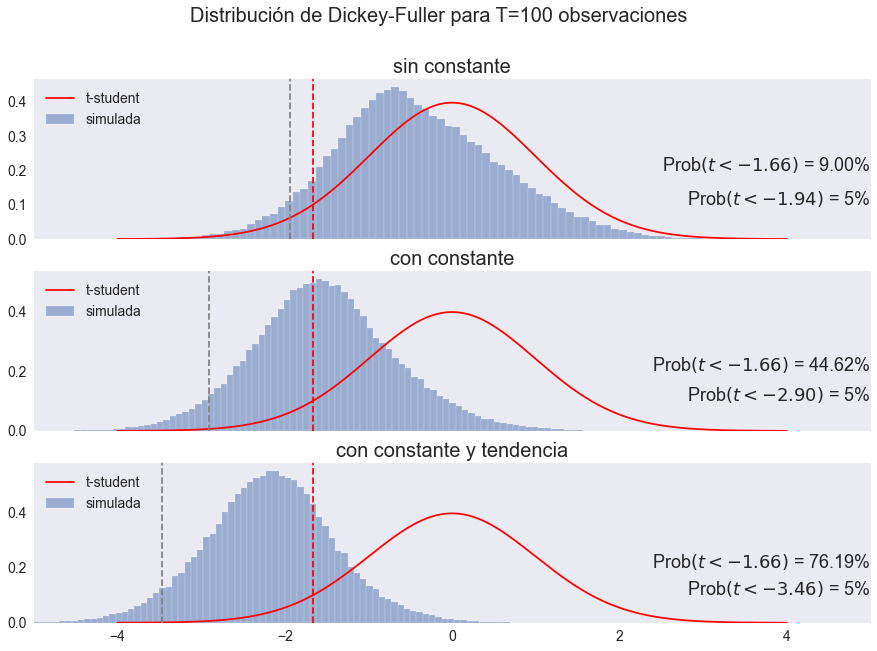

In [17]:
def plot_df(ax, data, titulo,df):
    maxtval = 5.0
    t5crit = t_Student.isf(0.05, df)

    ff, edges = np.histogram(data, bins=100, density=True)
    center = (edges[1:] + edges[:-1])/2
    w = center[1] - center[0]

    ax.bar(center, ff, width=w, alpha=0.5)
    xvals = np.linspace(-4,4, 200)
    ax.plot(xvals, t_Student.pdf(xvals, df=99), '-r')
    ax.set(xlim=[-maxtval, maxtval], title=titulo)
    ax.legend(['t-student', 'simulada'], loc='upper left')

    # valores críticos
    df5 = data.quantile(0.05)
    ax.axvline(-t5crit, ls="--", color='red')
    ax.axvline(df5, ls="--", color='gray')

    # error tipo I
    err1 = (data < -t5crit).mean()*100
    ax.annotate(f'Prob$\\left(t < -1.66\\right)$ = {err1:.2f}%', (5,0.2), size=18, ha='right')
    ax.annotate(f'Prob$\\left(t < {df5:.2f}\\right)$ = 5%', (5,0.1), size=18, ha='right')
    ax.grid(False)


fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=[15,10], sharex=True)

plot_df(ax0, dfvalues['nc'],'sin constante',99)
plot_df(ax1, dfvalues['c'],'con constante',98)
plot_df(ax2, dfvalues['ct'],'con constante y tendencia',97)

fig.suptitle('Distribución de Dickey-Fuller para T=100 observaciones', size=20)
fig.savefig('Dickey-Fuller.pdf', bbox_inches='tight')

### Potencia de la prueba

In [7]:
df5crit = dfvalues.quantile(0.05)
df5crit

nc   -1.947567
c    -2.894987
ct   -3.465096
Name: 0.05, dtype: float64

In [8]:
def df_simulacion_power(rho=0.95, T=101):
    e = np.random.randn(T)
    y = np.zeros(T)
    for t in range(1,T):
        y[t] = rho*y[t-1] + e[t]
    
    dy = y[1:] -y[:-1]
    X = sm.add_constant(y[:-1])
    Z = np.c_[X,np.arange(T-1)]
    
    res0 = sm.OLS(dy, y[:-1], hasconst=False).fit()
    res1 = sm.OLS(dy, X, hasconst=True).fit()
    res2 = sm.OLS(dy, Z, hasconst=True).fit()
    return res0.tvalues[0], res1.tvalues[1], res2.tvalues[1]

In [9]:
df_simulacion_power()

(-1.1737547077617012, -1.2382829396377597, -0.9006257921951432)

In [21]:
%%time
dfvaluespower = Monte_Carlo(df_simulacion_power, N, columnas=['nc','c','ct'])

Wall time: 41.1 s


In [22]:
def plot_df2(ax, data, spec, titulo,df):
    #maxtval = 5.0
    #t5crit = t.isf(0.05, df)

    ff, edges = np.histogram(data, bins=100, density=True)
    center = (edges[1:] + edges[:-1])/2
    w = center[1] - center[0]

    ax.bar(center, ff, width=w, alpha=0.5)
    #xvals = np.linspace(-4,4, 200)
    #ax.plot(xvals, t.pdf(xvals, df=99), '-r')
    ax.set(xlim=[-5, 2], title=titulo)
    

    # valores críticos
    df5 = df5crit[spec]
    ax.axvline(df5, ls="--", color='gray')
    ax.legend(['Valor crítico Dickey-Fuller', 'estadístico $t$ simulado'], loc='upper left')
    # error tipo II
    
    err2 = (data > df5).mean()*100
    ax.annotate(f'Prob$\\left(t > {df5:.2f}\\right)$ = {err2:.2f}%', (1.5,0.5), size=18, ha='right')
    ax.grid(False)

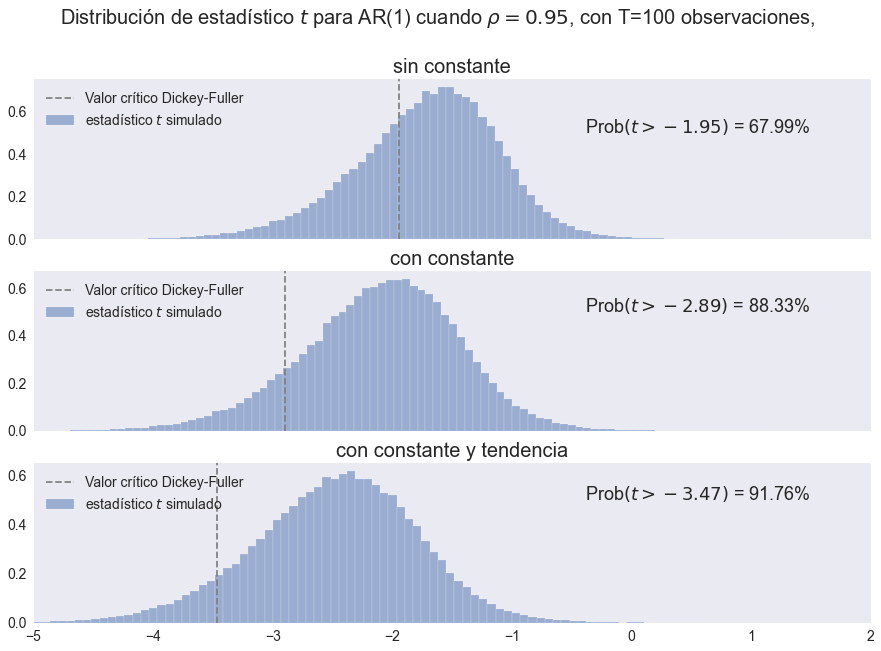

In [23]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=[15,10], sharex=True)

plot_df2(ax0, dfvaluespower['nc'],'nc','sin constante',99)
plot_df2(ax1, dfvaluespower['c'],'c','con constante',98)
plot_df2(ax2, dfvaluespower['ct'],'ct','con constante y tendencia',97)

fig.suptitle('Distribución de estadístico $t$ para AR(1) cuando $\\rho=0.95$, con T=100 observaciones, ', size=20)
fig.savefig('Dickey-Fuller-power.pdf', bbox_inches='tight')